In [1]:
import datetime as dt
import os
import requests
import time
from urllib import parse
from glob import glob

import pandas as pd
from bs4 import BeautifulSoup
# from selenium import webdriver
# from selenium.webdriver.common.keys import Keys
# from selenium.webdriver.common.by import By
from tqdm.notebook import tqdm, trange


base_url = "https://namu.wiki/w/"
logging_dir = "/home/nsw/datasets/namuwiki_scrapping_logs/"

# beautifulsoup

## graph

In [31]:
step = len(glob(logging_dir + ".xlsx"))
log_cols = ["parents", "key", "use"]
graph = dict()

In [32]:
if not os.path.isfile(logging_dir + "result_step_00.xlsx"):
    pd.DataFrame([("root", "우왁굳", 1)], columns=log_cols).to_excel(logging_dir + f"result_step_{step:02d}.xlsx", index=None)

In [27]:
def make_node(title: str, children: list):
    return {
        "title": title,
        "url": parse.quote(base_url + title),
        "children": [ch[1] for ch in children],
    }

In [45]:
key_df = pd.read_excel(logging_dir + f"result_step_{step:02d}.xlsx")
for _, row in key_df.iterrows():
    if pd.isna(row['use']):
        graph[row['parents']]['children'].remove(row['key'])

keys = key_df.dropna().key.to_list()

# keys = pd.read_excel(logging_dir + f"result_step_{step:02d}.xlsx").key.dropna().to_list()
step += 1
new_keys = []
for key in tqdm(keys):
    if key in graph:
        # print(key, ": continue")
        continue
    soup = BeautifulSoup(requests.get(base_url + key).text, 'html.parser')

    index = soup.select_one("div.toc-indent")
    if index == None:
        children = []
    else:
        children = [
            (key, parse.unquote(link.get_attribute_list("href")[0].split("/", 2)[-1]), 1)
            for link in index.select("a.wiki-link-internal")
        ]

    node = make_node(key, children)
    graph[key] = node
    # print(key, children)

    new_keys += children

# new_keys
pd.DataFrame(new_keys, columns=log_cols).to_excel(logging_dir + f"result_step_{step:02d}.xlsx", index=None)

  0%|          | 0/101 [00:00<?, ?it/s]

In [25]:
graph.keys()

dict_keys(['우왁굳', '우왁굳/방송 역사', '왁두', '우왁굳/특징', '우왁굳/별명 및 밈', '우왁굳/콘텐츠', '우왁굳/플레이한 게임', '침팬치', '왁물원', '우왁굳TV', '왁카데미', '우왁굳/콘텐츠/고정 멤버', '이세계아이돌', '왁타버스 중간계', '우왁굳/논란 및 사건 사고', '우왁굳/어록', '오뱅계르크', '우왁굳/연도별 행적', '아프리카TV', '왁두/파생형', '우왁굳/콘텐츠/게임', '우왁굳/콘텐츠/비게임', '왁타버스', '고멤 놀이터', '왁물원/이세계아이돌 게시판', '왁물원/인력사무소', '우왁굳/콘텐츠/비게임/연말 공모전', '왁물원/규정', '네이버 카페', '왁물원/역사', '개복어', '노돌리', '레알마틴', '렘쨩', '로복', '무결', '조마문', '조매력', '천양', '크헐헐', '도그홀', '두칠', '바나나(인터넷 방송인)', '진호(인터넷 방송인)', '함군', '겜스터', '휘용', '고니잠', '주르르', '우왁굳/콘텐츠/고정 멤버/0기', '왁타버스 고정 멤버', '고멤 아카데미', '이세계아이돌/멤버 간 케미', '이세계아이돌/오디션', '이세계아이돌/활동', '이세계아이돌/공연 및 행사', '이세계아이돌/음반 목록', '이세계아이돌/오리지널 곡', '이세계아이돌/커버 곡', '마법소녀 이세계아이돌', '차원을 넘어 이세계아이돌', '이파리', '이세계아이돌/응원법', '이세계아이돌/굿즈', '이세계아이돌/이모티콘', '이세계아이돌/월드', '이세계아이돌/여담', '2020년 유튜버 뒷광고 사건'])

In [30]:
graph['우왁굳/논란 및 사건 사고']['children']

[('우왁굳/논란 및 사건 사고', 'One Hour One Life'),
 ('우왁굳/논란 및 사건 사고', '그리핑'),
 ('우왁굳/논란 및 사건 사고', '2020년 유튜버 뒷광고 사건'),
 ('우왁굳/논란 및 사건 사고', '왁타버스')]

## Tree  
`분류:` 항목 참고한 트리구조(그래프x)

In [2]:
def make_tree_node(
    title: str, 
    parents: str, 
    subcategory: list, 
    subdocs: list, 
    subform: list
):
    return {
        "title": title,
        "url": base_url + parse.quote("분류:" + title),
        "parents": parents,
        "subcategory": subcategory,
        "subdocs": subdocs,
        "subform": subform,
    }

In [3]:
tree = {}
next_keys = [("root", "우왁굳")]

while len(next_keys) > 0:
    keys = next_keys
    next_keys = []

    for parents, key in tqdm(keys, leave=False):
        if key in tree:
            continue
        soup = BeautifulSoup(requests.get(base_url + "분류:" + key).text, 'html.parser')

        subcategory = soup.select_one("#category-분류")
        subdocs = soup.select_one("#category-문서")
        subform = soup.select_one("#category-틀")
        
        subcategory = [] if subcategory is None else [tag.get_attribute_list("title")[0].split(":", 1)[-1] for tag in subcategory.select("a")]
        subdocs = [] if subdocs is None else [tag.get_attribute_list("title")[0] for tag in subdocs.select("a")]
        subform = [] if subform is None else [tag.get_attribute_list("title")[0].split(":", 1)[-1] for tag in subform.select("a")]

        node = make_tree_node(key, parents, subcategory, subdocs, subform)
        tree[key] = node
        # print(key, children)
    
        next_keys += [(key, sc) for sc in subcategory]

    print(next_keys)

  0%|          | 0/1 [00:00<?, ?it/s]

[('우왁굳', '왁물원'), ('우왁굳', '우왁굳/밈'), ('우왁굳', '우왁굳/콘텐츠'), ('우왁굳', '파일/우왁굳')]


  0%|          | 0/4 [00:00<?, ?it/s]

[('우왁굳/콘텐츠', '왁타버스'), ('우왁굳/콘텐츠', '우왁굳/콘텐츠/게임'), ('우왁굳/콘텐츠', '우왁굳/콘텐츠/고정 멤버'), ('파일/우왁굳', '파일/고멤 가요제'), ('파일/우왁굳', '파일/왁타버스')]


  0%|          | 0/5 [00:00<?, ?it/s]

[('왁타버스', '2023 왁타버스 뮤직 어워즈'), ('왁타버스', '고멤 가요제'), ('왁타버스', '고멤 아카데미'), ('왁타버스', '왁타버스 고정 멤버'), ('왁타버스', '왁타버스 관련 VR챗 월드'), ('왁타버스', '왁타버스 작곡캠프'), ('왁타버스', '왁타버스/오리지널 곡'), ('왁타버스', '이세계아이돌'), ('왁타버스', '파일/왁타버스'), ('우왁굳/콘텐츠/게임', '우왁굳/콘텐츠/게임/VR챗'), ('우왁굳/콘텐츠/게임', '티바로살래나'), ('우왁굳/콘텐츠/고정 멤버', '고멤 아카데미'), ('우왁굳/콘텐츠/고정 멤버', '왁타버스 고정 멤버'), ('파일/왁타버스', '파일/고멤 아카데미'), ('파일/왁타버스', '파일/왁타버스 고정 멤버'), ('파일/왁타버스', '파일/이세계아이돌')]


  0%|          | 0/16 [00:00<?, ?it/s]

[('고멤 가요제', '고멤 가요제/노래'), ('고멤 가요제', '고멤 가요제/팀'), ('고멤 가요제', '파일/고멤 가요제'), ('고멤 아카데미', '고멤 아카데미/소속 멤버'), ('고멤 아카데미', '고멤 아카데미/오리지널 곡'), ('고멤 아카데미', '파일/고멤 아카데미'), ('왁타버스 고정 멤버', '왁타버스 고정 멤버/소속 멤버'), ('왁타버스 고정 멤버', '왁타버스 고정 멤버/시즌'), ('왁타버스 고정 멤버', '왁타버스 고정 멤버/오리지널 곡'), ('왁타버스 고정 멤버', '파일/왁타버스 고정 멤버'), ('왁타버스/오리지널 곡', '고멤 아카데미/오리지널 곡'), ('왁타버스/오리지널 곡', '왁타버스 고정 멤버/오리지널 곡'), ('왁타버스/오리지널 곡', '이세계아이돌/오리지널 곡'), ('이세계아이돌', '이세계아이돌/2차 창작'), ('이세계아이돌', '고세구'), ('이세계아이돌', '이세계아이돌/공연 및 행사'), ('이세계아이돌', '둘러보기 틀/이세계아이돌'), ('이세계아이돌', '릴파'), ('이세계아이돌', '마법소녀 이세계아이돌'), ('이세계아이돌', '비챤'), ('이세계아이돌', '아이네'), ('이세계아이돌', '이세계아이돌/오리지널 곡'), ('이세계아이돌', '이세계아이돌/음반'), ('이세계아이돌', '이파리'), ('이세계아이돌', '주르르'), ('이세계아이돌', '징버거'), ('이세계아이돌', '차원을 넘어 이세계아이돌'), ('이세계아이돌', '파일/이세계아이돌'), ('우왁굳/콘텐츠/게임/VR챗', '2023 왁타버스 뮤직 어워즈'), ('우왁굳/콘텐츠/게임/VR챗', '고멤 가요제'), ('파일/이세계아이돌', '파일/고세구'), ('파일/이세계아이돌', '파일/릴파'), ('파일/이세계아이돌', '파일/비챤'), ('파일/이세계아이돌', '파일/아이네'), ('파일/이세계아이돌', '파일/주르르'), ('파일/이세계아이돌', '파일/징버거')]


  0%|          | 0/36 [00:00<?, ?it/s]

[('왁타버스 고정 멤버/오리지널 곡', '고멤 가요제/노래'), ('고세구', 'TOUR'), ('고세구', '파일/고세구'), ('이세계아이돌/공연 및 행사', 'TOUR'), ('릴파', '파일/릴파'), ('마법소녀 이세계아이돌', '마법소녀 이세계아이돌/등장인물'), ('비챤', '파일/비챤'), ('아이네', '파일/아이네'), ('주르르', '파일/주르르'), ('징버거', '파일/징버거'), ('차원을 넘어 이세계아이돌', '차원을 넘어 이세계아이돌/등장인물')]


  0%|          | 0/11 [00:00<?, ?it/s]

[]


In [4]:
len(tree)

53

In [25]:
soup = BeautifulSoup(requests.get(base_url + '우왁굳').text, 'html.parser')
soup.select('body')

[<body><div data-server-rendered="true" id="app"><!-- --><main class="amWnEijR narrow-layout Q1aAcEtq" data-v-a3f5bb80=""><div class="tfJBOXOm JxOYivlR" data-v-90eb49a4="" data-v-a3f5bb80=""><div class="syR5oDu3" data-v-90eb49a4=""><a class="J6aW+Qmd" data-v-90eb49a4="" href="/" title="나무위키"></a> <div class="ZFT2OpOy" data-v-90eb49a4=""><a class="KW4U0vyf" data-v-90eb49a4="" href="/RecentChanges"><svg class="EeI7iAsH" data-v-90eb49a4="" height="1em" viewbox="0 0 512 512" xmlns="http://www.w3.org/2000/svg"><path d="M256 0a256 256 0 1 1 0 512A256 256 0 1 1 256 0zM232 120V256c0 8 4 15.5 10.7 20l96 64c11 7.4 25.9 4.4 33.3-6.7s4.4-25.9-6.7-33.3L280 243.2V120c0-13.3-10.7-24-24-24s-24 10.7-24 24z"></path></svg> <span class="w6CbsQ0E" data-v-90eb49a4="">최근 변경</span></a> <a class="KW4U0vyf" data-v-90eb49a4="" href="/RecentDiscuss"><svg class="EeI7iAsH" data-v-90eb49a4="" height="1em" viewbox="0 0 640 512" xmlns="http://www.w3.org/2000/svg"><path d="M208 352c114.9 0 208-78.8 208-176S322.9 0 208 

### head, content

In [7]:
head = soup.select('.wiki-heading')
content = soup.select('.wiki-heading-content')
print(len(head), len(content))

23 23


In [65]:
from markdownify import markdownify as md

i = 4

print(md(str(head[i])))
print(md(str(content[i])))

print("\n", "=" * 50, "\n")
# TODO: '.wiki-fn-content' 항목 parse.quote 함수로 title 필드 url 고치기
# for external_link in content[i].select('.wiki-fn-content'):
#     print(external_link.text, external_link.get("title"))

# print(head[i].text, "\n")
print(content[i])


### [2.3.](#toc) 이모티콘 및 구독 배지[[편집]](/edit/%EC%9A%B0%EC%99%81%EA%B5%B3?section=5)


![우왁굳 이모티콘 2022 09](//i.namu.wiki/i/ep8X5-qioo1dlMqfRaOw8hZ_1jtYFSmpFNiyCX4-dZArM1YzErxM-EpRgZuHfRMR8YsHcJSyaDF_H1aQwbbfZ31c4foPR-nXleRbBzyIh7vt-JrOSqGvuoU3klC9OslVpg2d1Ej7slUtmWq2CO_viw.webp)  



<div class="wiki-heading-content" data-v-191e336f="" data-v-5aa3932c=""><div class="wiki-paragraph" data-v-191e336f=""><span class="wiki-image-align-normal" data-v-191e336f=""><span class="wiki-image-wrapper" data-v-191e336f=""><img alt="우왁굳 이모티콘 2022 09" data-v-191e336f="" src="//i.namu.wiki/i/ep8X5-qioo1dlMqfRaOw8hZ_1jtYFSmpFNiyCX4-dZArM1YzErxM-EpRgZuHfRMR8YsHcJSyaDF_H1aQwbbfZ31c4foPR-nXleRbBzyIh7vt-JrOSqGvuoU3klC9OslVpg2d1Ej7slUtmWq2CO_viw.webp"/></span></span><br data-v-191e336f=""/></div></div>


In [66]:
text = ""

for h, c in zip(head, content):
    text += md(str(h)) + "\n"
    text += md(str(c)) + "\n"

with open("test.md", "w", encoding="utf-8") as f:
    f.write(text)

[1.](#toc) 개요[[편집]](/edit/%EC%9A%B0%EC%99%81%EA%B5%B3?section=1)
----------------------------------------------------------------



> 안녕하세요, 사랑하는 유튜브 시청자 여러분들 반갑습니다. 우왁굳입니다. 오늘 여러분께 보여드릴 컨텐츠는?
> 
> ---
> 
> [유튜브 오프닝 멘트](https://youtu.be/mEL2NaCEfRc "https://youtu.be/mEL2NaCEfRc")[[26]](#fn-26 "마인크래프트 배치고사")

우왁굳은 [아프리카TV](/w/%EC%95%84%ED%94%84%EB%A6%AC%EC%B9%B4TV "아프리카TV")에서 활동하는 [대한민국](/w/%EB%8C%80%ED%95%9C%EB%AF%BC%EA%B5%AD "대한민국")의 [인터넷 방송인](/w/%EC%9D%B8%ED%84%B0%EB%84%B7%20%EB%B0%A9%EC%86%A1%EC%9D%B8 "인터넷 방송인"), [작사가](/w/%EC%9E%91%EC%82%AC%EA%B0%80 "작사가") 임과 동시에 [이세계아이돌](/w/%EC%9D%B4%EC%84%B8%EA%B3%84%EC%95%84%EC%9D%B4%EB%8F%8C "이세계아이돌")의 총괄 [프로듀서](/w/%ED%94%84%EB%A1%9C%EB%93%80%EC%84%9C "프로듀서")이자 [왁 엔터테인먼트](/w/%EC%99%81%20%EC%97%94%ED%84%B0%ED%85%8C%EC%9D%B8%EB%A8%BC%ED%8A%B8 "왁 엔터테인먼트")의 설립자이다.  
  
2008년부터 방송을 시작하여[[27]](#fn-27 "윈앰프, W플레이어 시절의 노래 및 애니메이션, 영화 단체 시청 등의 포맷을 띤 초기 인터넷 방송까지 포함하면 그가 바부코리아의 부운영자를 맡고 있던 2002년까지 거슬러 올라간다.") 약 15년의 긴 방송 경력을 가지고 있는 1세대 인터넷 방송인이다. 트위치 전 세계 랭킹 28위 / 국내 랭킹 1위였고[[28]](#fn-28 "(2023년 1월 14일 기준) 각종 수치를 통합한 순위이다. #") 2023년 9월 5일에는 트위치 팔로워 100만을 돌파하였다.[[29]](#fn-29 "프로게이머 이상혁에 이은 국내 인터넷 방송인 중 트위치 팔로워 100만을 돌파한 두번째 스트리머였다.") 이후 아프리카TV로 이적하며 활동을 이어나가고 있다.  

### table

In [55]:
tables = soup.select("table.wiki-table")
# print(md(str(tables[4])))

## draw graph

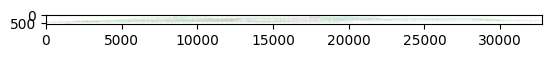

In [25]:
import pydot
import matplotlib.pyplot as plt
import matplotlib.image as img

graph = pydot.Dot(graph_type='graph', charset="UTF-8", fontname="malgun")

for node in tree.values():
    for sub in node['subcategory']:
        graph.add_edge(pydot.Edge(node['title'], sub, color="blue"))
    for sub in node['subdocs']:
        graph.add_edge(pydot.Edge(node['title'], sub, color="green"))
    for sub in node['subform']:
        graph.add_edge(pydot.Edge(node['title'], sub, color="red"))

graph.write_png('./graph.png')

img_test = img.imread('./graph.png')
plt.imshow(img_test)
plt.show()